In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
MtWashington_weather = pd.read_csv('MtWashingtonDailyTemps.csv', index_col='DATE', parse_dates=True)
MtWashington_weather.head()

,MinTemp,MaxTemp,AvgTemp,AvgWindSpeed,Sunrise,Sunset
DATE,,,,,,
2014-12-01,3,36,20,65.1,700,1608
2014-12-02,1,22,12,34.7,702,1607
2014-12-03,8,32,20,53.0,703,1607
2014-12-04,-5,9,2,60.2,704,1607
2014-12-05,6,17,12,30.5,705,1607


The weather data is aggregated by day. The following plot shows the minimum temperatures each day.

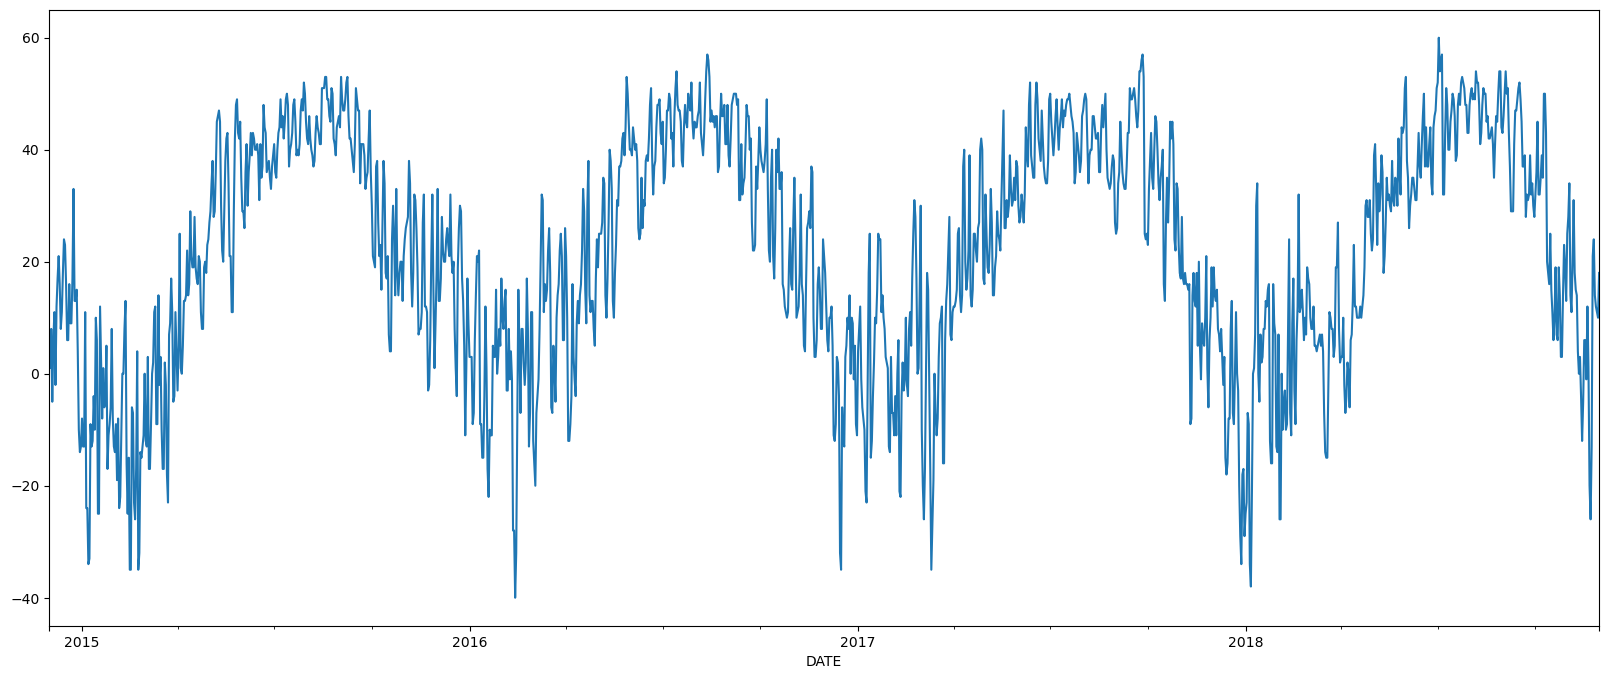

In [3]:
MtWashington_weather.MinTemp.plot(figsize=(20, 8));

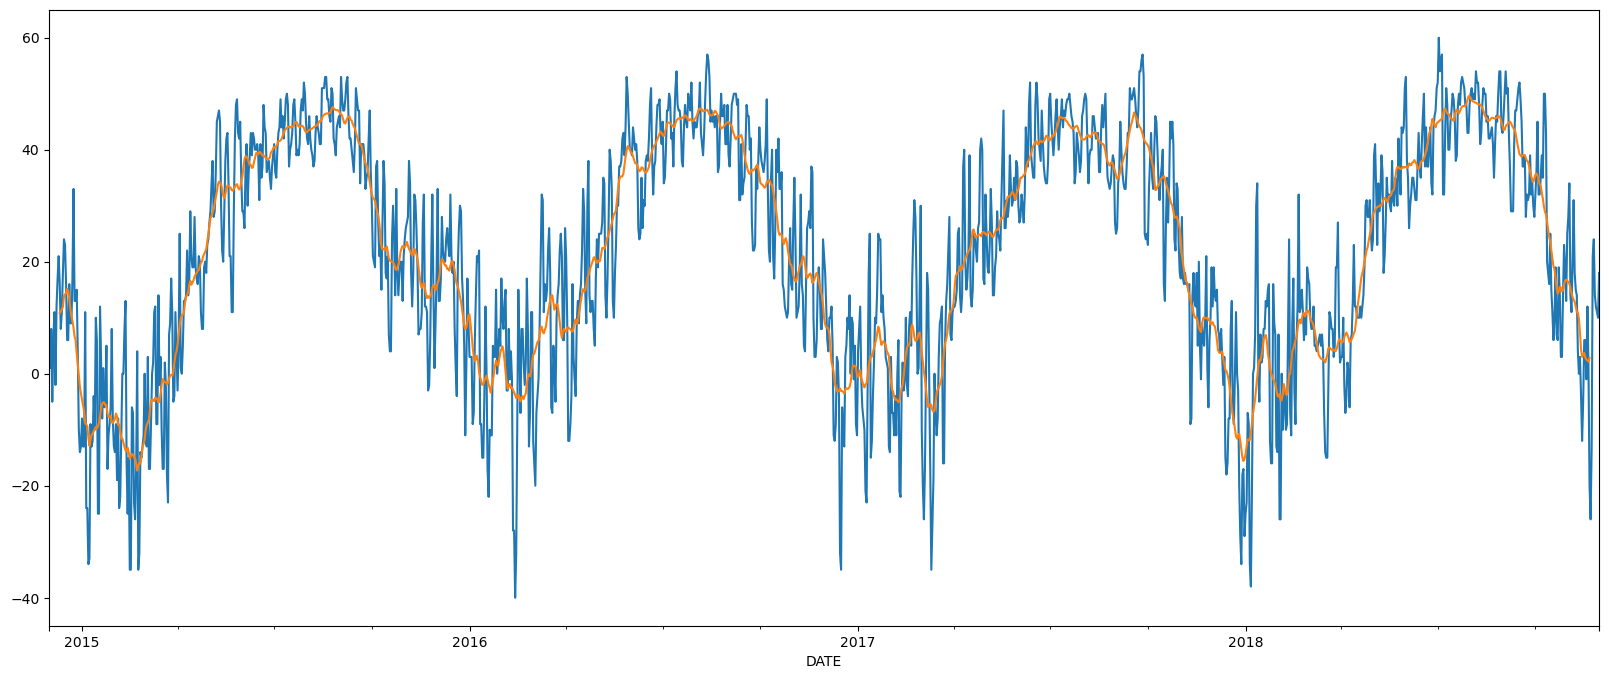

In [4]:
# Moving average smoothing with a = 20
MinTemp_smoothed = MtWashington_weather['MinTemp'].rolling(20, center = True).mean()
MtWashington_weather['MinTemp'].plot(figsize=(10, 5));
MinTemp_smoothed.plot(figsize=(20, 8));

The smoothing parameter of 20 does not seem like enough to capture the development of the data, so perhaps we can increase this to 50 and see how it looks. Here, we have a choice as to what parameter to use, and it is more a matter of personal taste, but does not make a huge difference to use 20 or 50. 

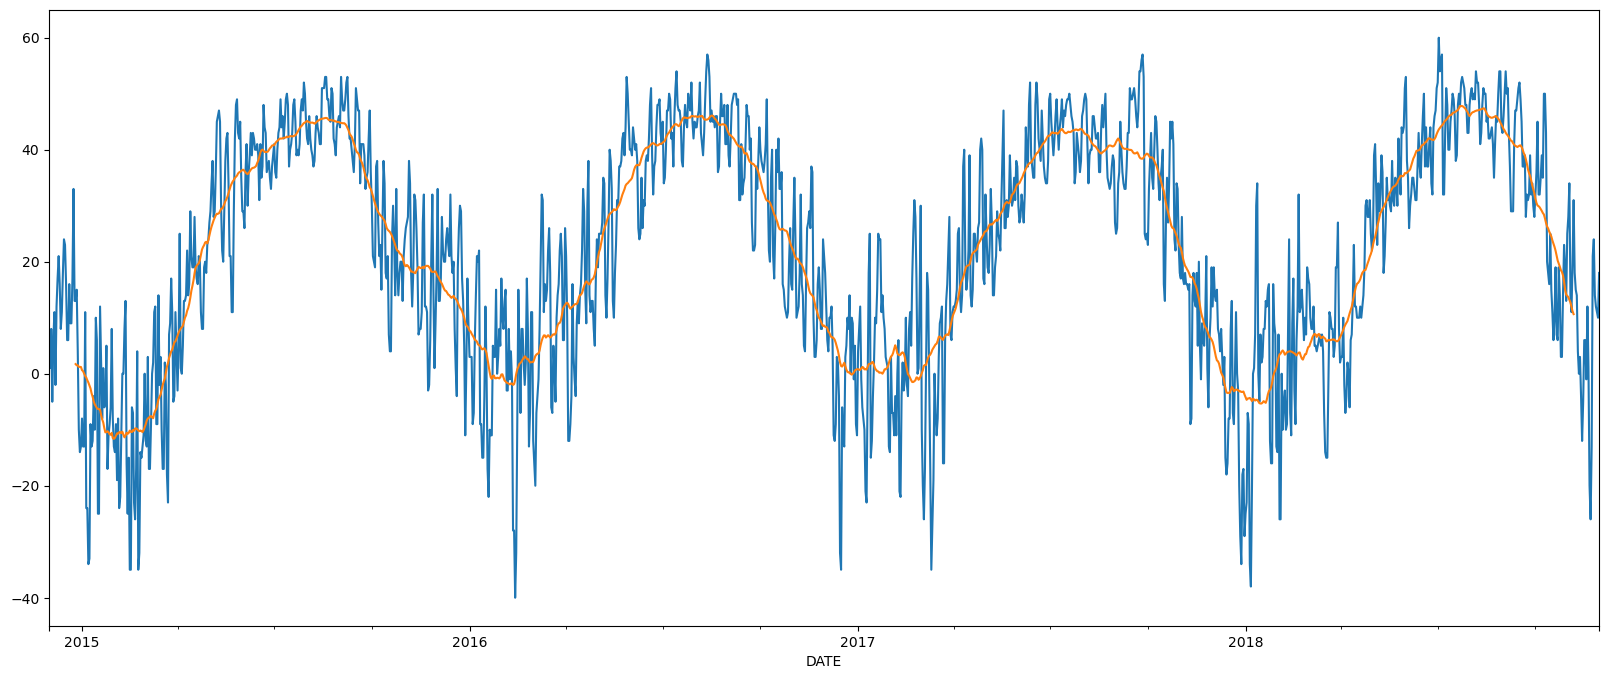

In [5]:
# Moving average smoothing with a = 50
MinTemp_masmoothed = MtWashington_weather['MinTemp'].rolling(50, center = True).mean()
MtWashington_weather['MinTemp'].plot(figsize=(20, 8))
MinTemp_masmoothed.plot(figsize=(20, 8));

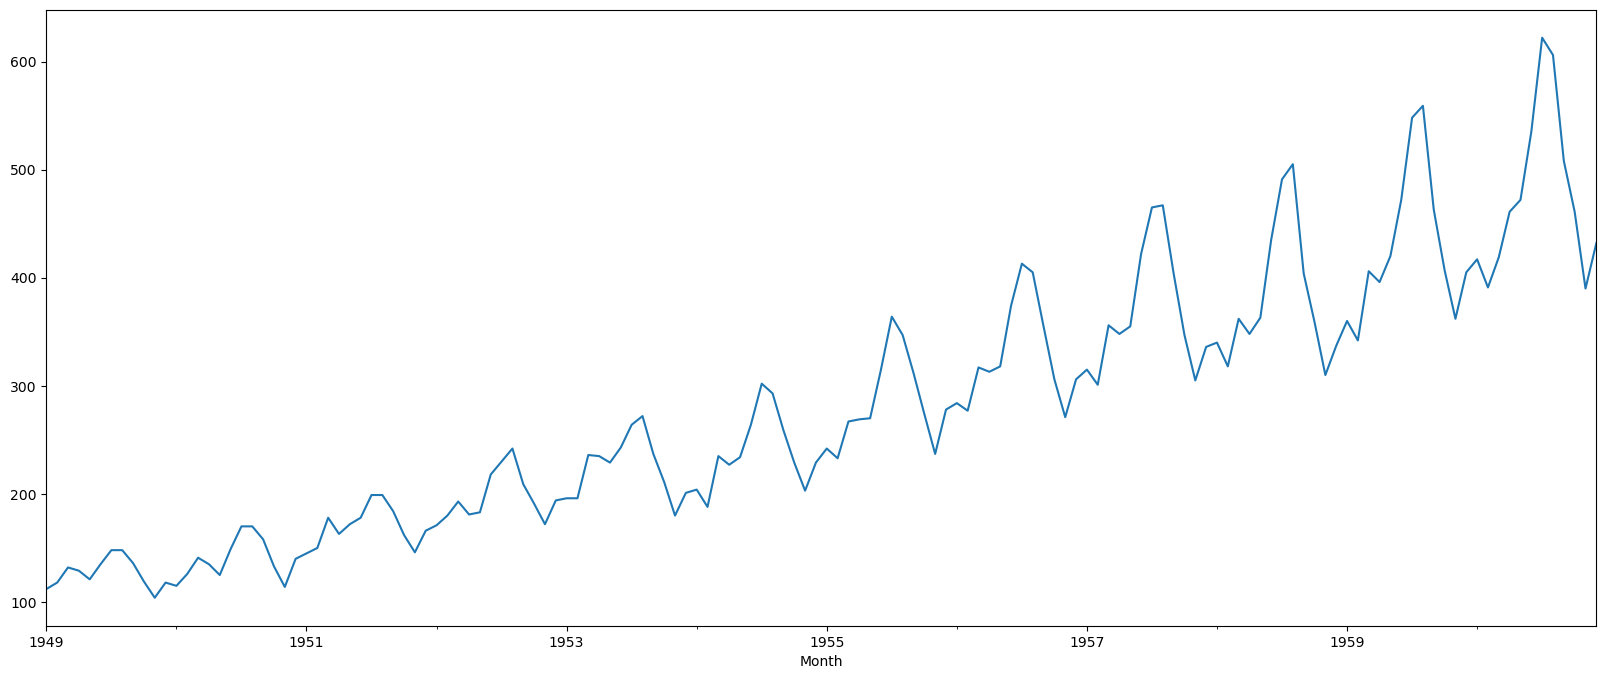

In [6]:
###### Classical Time Series Decomposition
airline_passengers = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)
airline_passengers['Passengers'].plot(figsize=(20, 8));

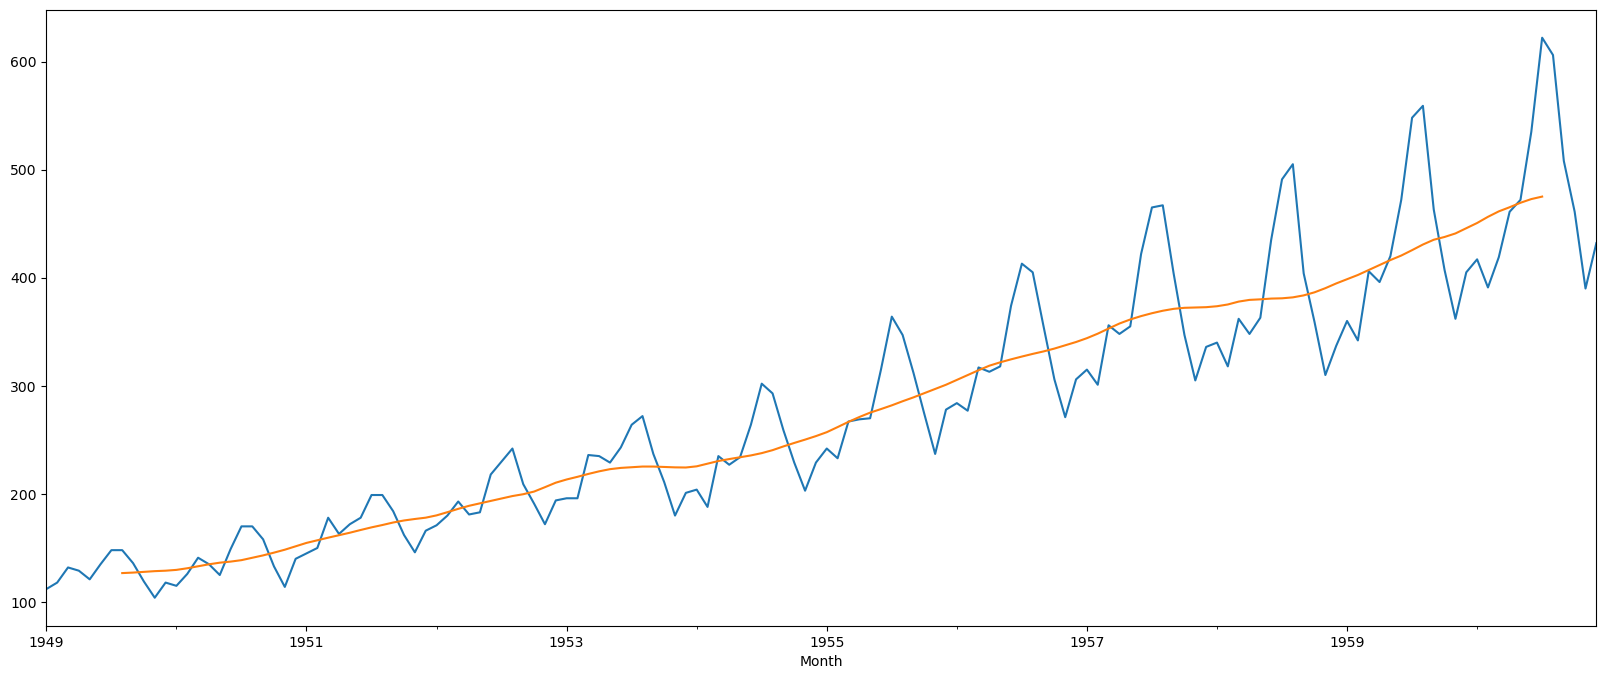

In [7]:
# Moving average smoothing with a = 12
passengers_masmoothed = airline_passengers['Passengers'].rolling(12, center = True).mean()
passengers_masmoothed = passengers_masmoothed.rolling(2, center = True).mean()
airline_passengers['Passengers'].plot(figsize=(20, 8))
passengers_masmoothed.plot(figsize=(20, 8));

12 is an even number, so in order to remove the seasonality, we need to use window size 2. This effectively removes the seasonality.  

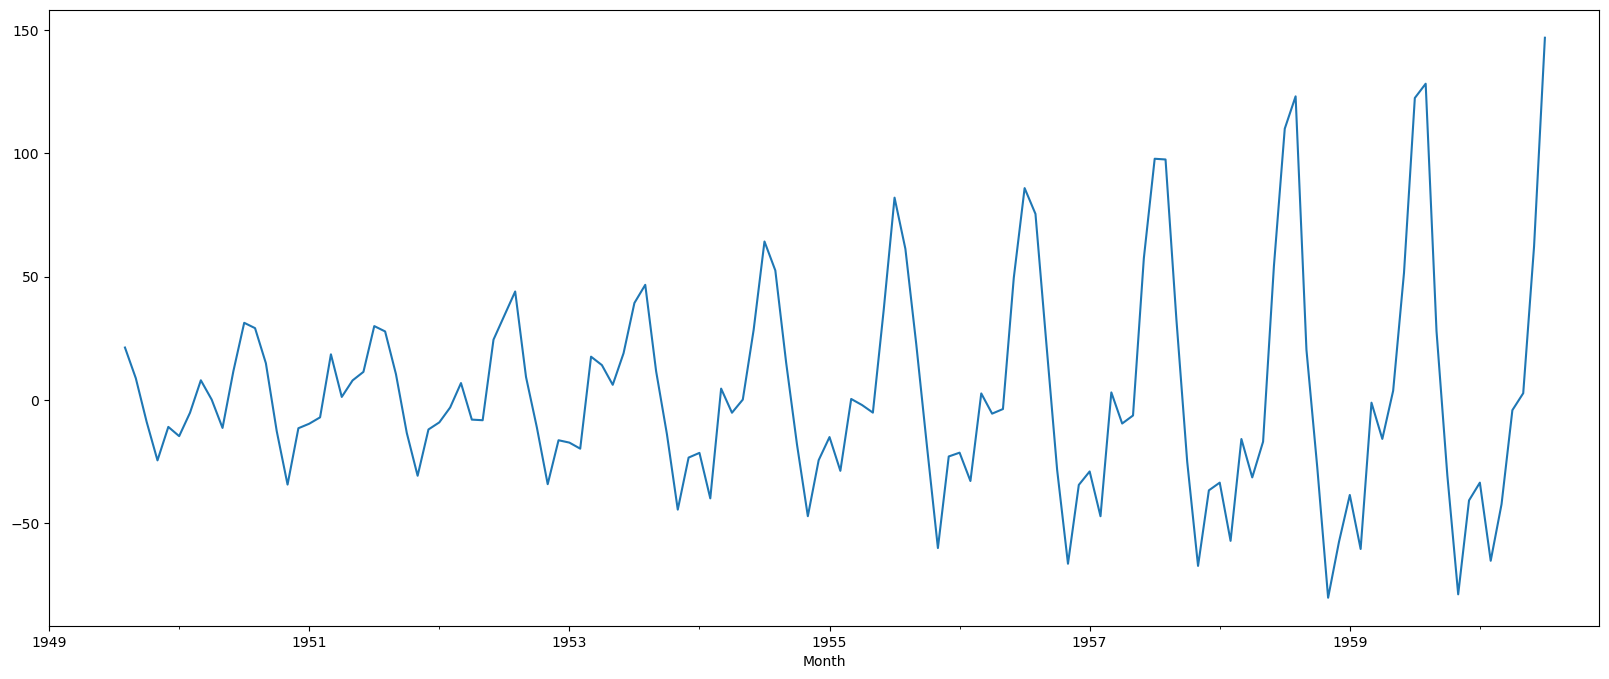

In [8]:
# Additive decomposition 
passengers_detrended_add = airline_passengers['Passengers'] - passengers_masmoothed
passengers_detrended_add.plot(figsize=(20, 8));

This is the detrend series, and you can see that the seasonality increases overtime. So, additive decomposition is clearly not the best choice. 

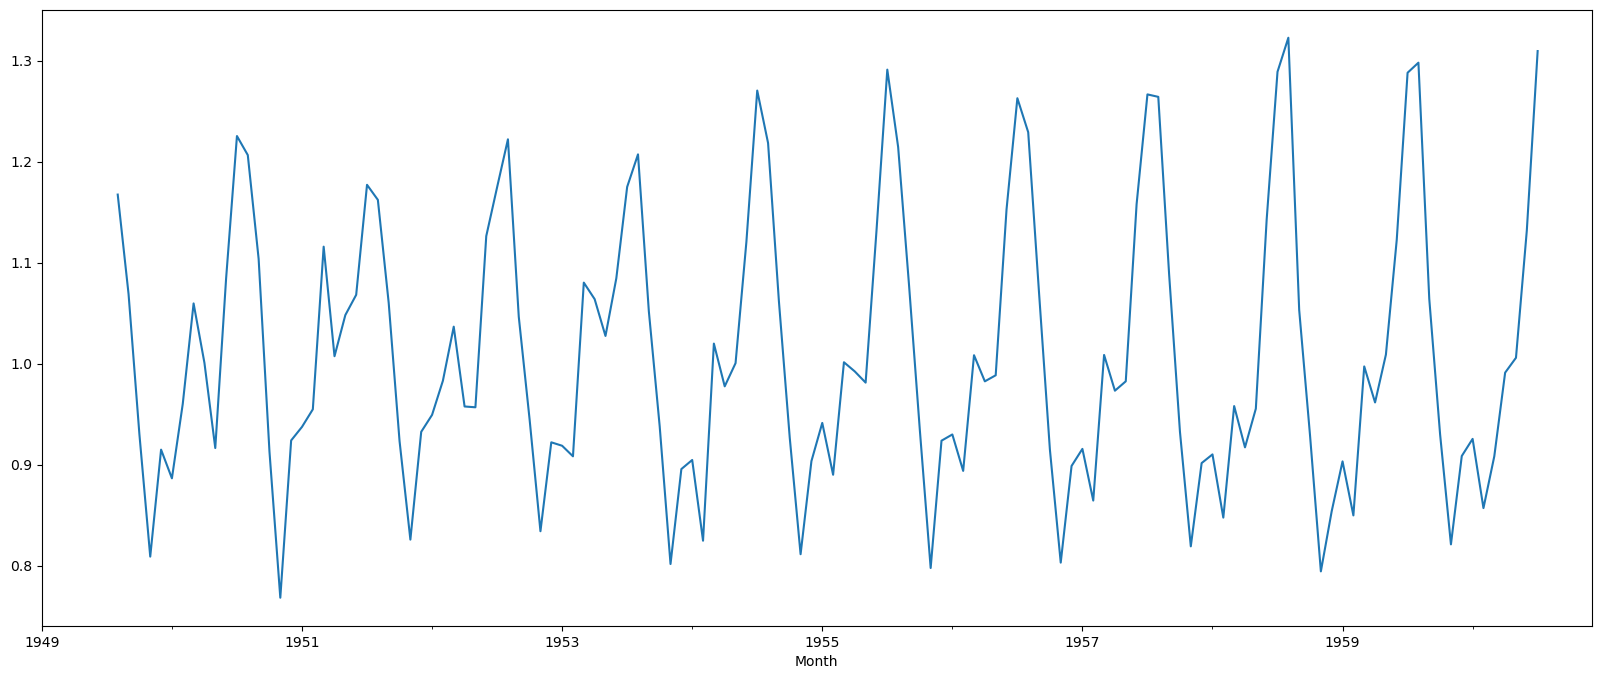

In [9]:
#multiplicative decomposition
passengers_detrended_mult = airline_passengers['Passengers']/passengers_masmoothed
passengers_detrended_mult.plot(figsize=(20, 8));

This looks much better, so now we have a detrended series, where the seasonality does not seem to change too much as compared to the previous plot. 

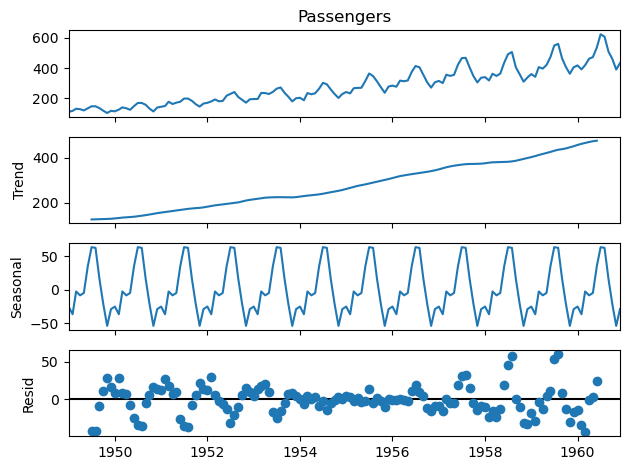

In [10]:
# automatiszed classical additive decomposition
passengers_class_add = seasonal_decompose(airline_passengers['Passengers'], model='additive')
passengers_class_add.plot();

We have classical decomosition here, automated by python. So, we have a lot of very large residuals at tbe beginning as seen in the resid plot, because here the seasonality component overestimates the seasonality, and also underestimates the seasonality. So, it is better to use multiplicative decomposition as seen in the next plots. 

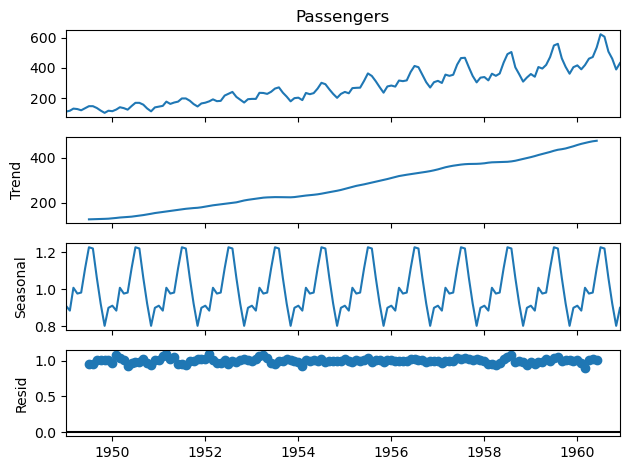

In [11]:
# automatiszed classical multiplicative decomposition
passengers_class_mult = seasonal_decompose(airline_passengers['Passengers'], model='multipliative')
passengers_class_mult.plot();

Here, the resids are much more stable. 

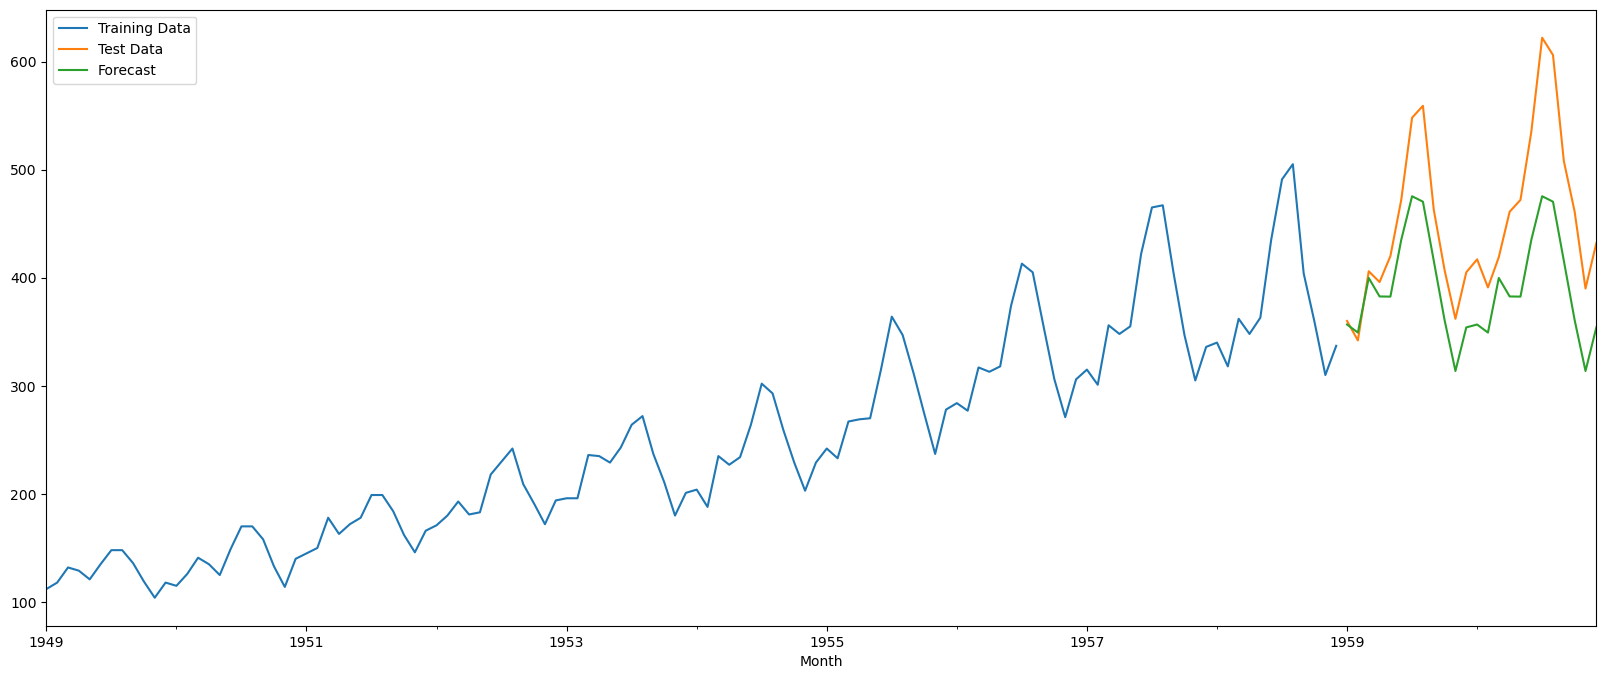

In [25]:
# Forecasting with classical decomposition
# Separate the series into training and test data
train = airline_passengers[0:120] 
test = airline_passengers[120:]

# Decompose the training data via classical decomposition
train_class_mult = seasonal_decompose(train['Passengers'], model='multiplicative')
# Save components as separate variables
train_class_mult  = pd.concat(
    [train_class_mult.seasonal, 
     train_class_mult.trend, 
     train_class_mult.resid, 
     train_class_mult.trend * train_class_mult.resid, 
     train_class_mult.observed], axis=1)
train_class_mult.columns = ['seasonal', 'trend', 'remainders', 'seasonal_adj', 'actual_values']

# Create a forecast dataframe for 24 months with the same columns as train_class_mult and the seasonal component 
class_forecast = train_class_mult.iloc[-24:,:]
# Set the index to that of the test series
class_forecast.index = test.index
class_forecast = class_forecast.drop('actual_values', axis=1)
class_forecast[['trend', 'remainders', 'seasonal_adj']] = np.nan

# Naive forecast for trend and remainders
class_forecast['trend'] = train_class_mult.loc[train_class_mult.index[-7], 'trend']
class_forecast['remainders'] = train_class_mult.loc[train_class_mult.index[-7], 'remainders']
class_forecast['seasonal_adj'] = class_forecast['trend'] * class_forecast['remainders']
# Forecast based on naive forecast of seasonally adjusted component and seasonal component
class_forecast['forecast'] = class_forecast['seasonal_adj'] * class_forecast['seasonal']

plt.figure(figsize=(20, 8))
train["Passengers"].plot(label='Training Data')
test["Passengers"].plot(label='Test Data')
class_forecast['forecast'].plot(label='Forecast')
plt.legend();


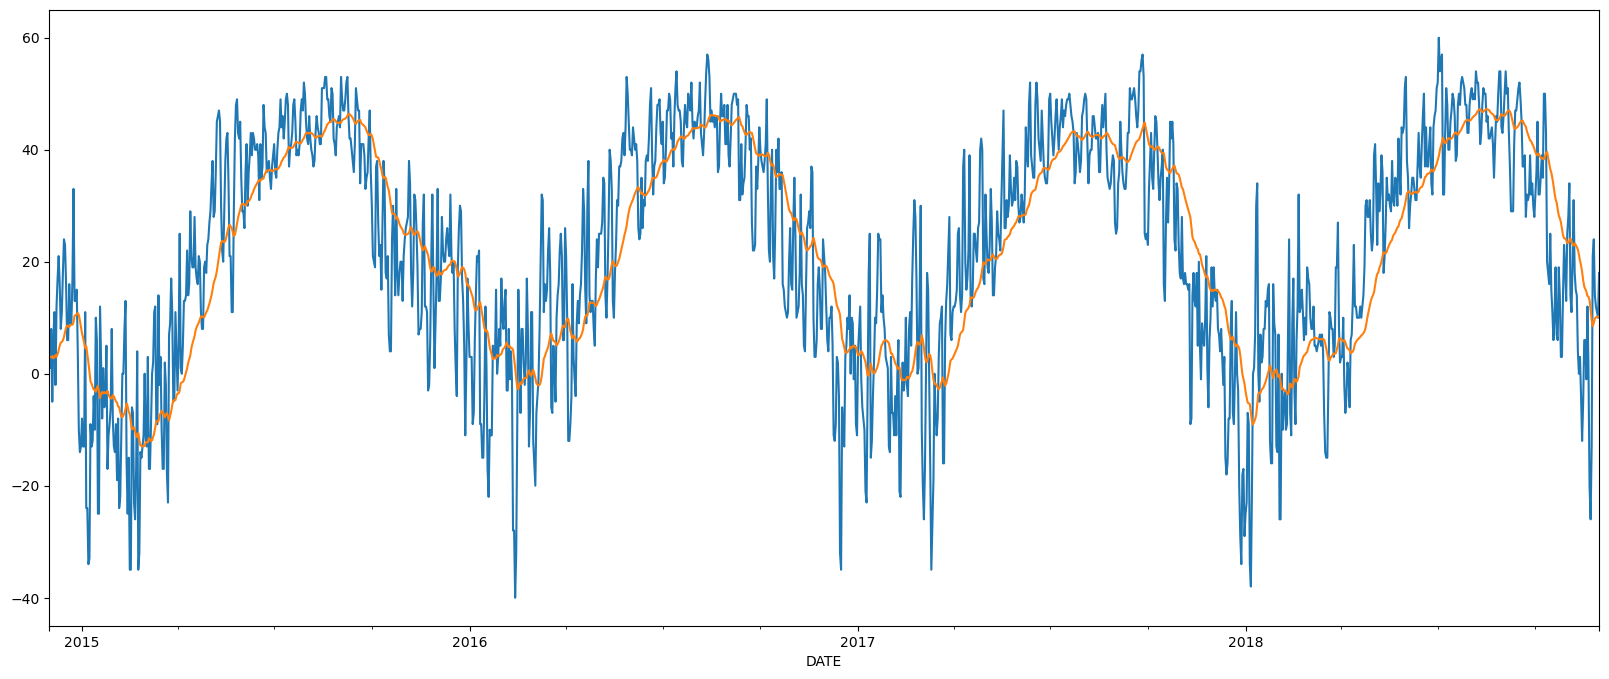

In [13]:
##### Exponential Smoothing
# Simple exponential smoothing with alpha = 0.05
MinTemp_expsmoothed = SimpleExpSmoothing(MtWashington_weather['MinTemp']).fit(smoothing_level = 0.05).fittedvalues
MtWashington_weather['MinTemp'].plot(figsize=(20, 8))
MinTemp_expsmoothed.plot(figsize=(20, 8));


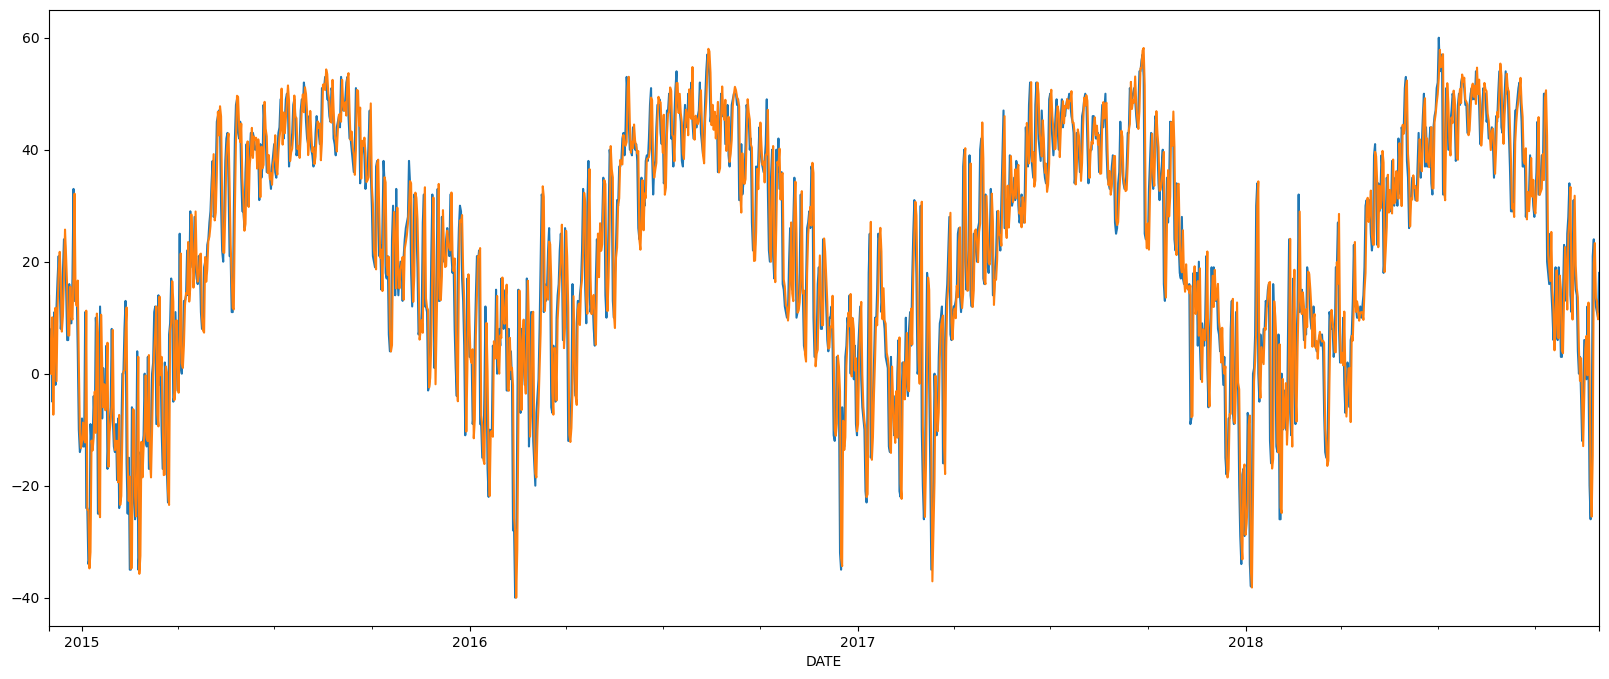

In [14]:
# Holt-Winter's seasonal method with additive trend and seasonality
MtWashington_weather['MinTemp_HoltW'] = ExponentialSmoothing(MtWashington_weather['MinTemp'],  trend = "add",seasonal="add",seasonal_periods=12).fit().fittedvalues
MtWashington_weather['MinTemp'].plot(figsize=(20, 8))
MtWashington_weather['MinTemp_HoltW'].plot(figsize=(20, 8));

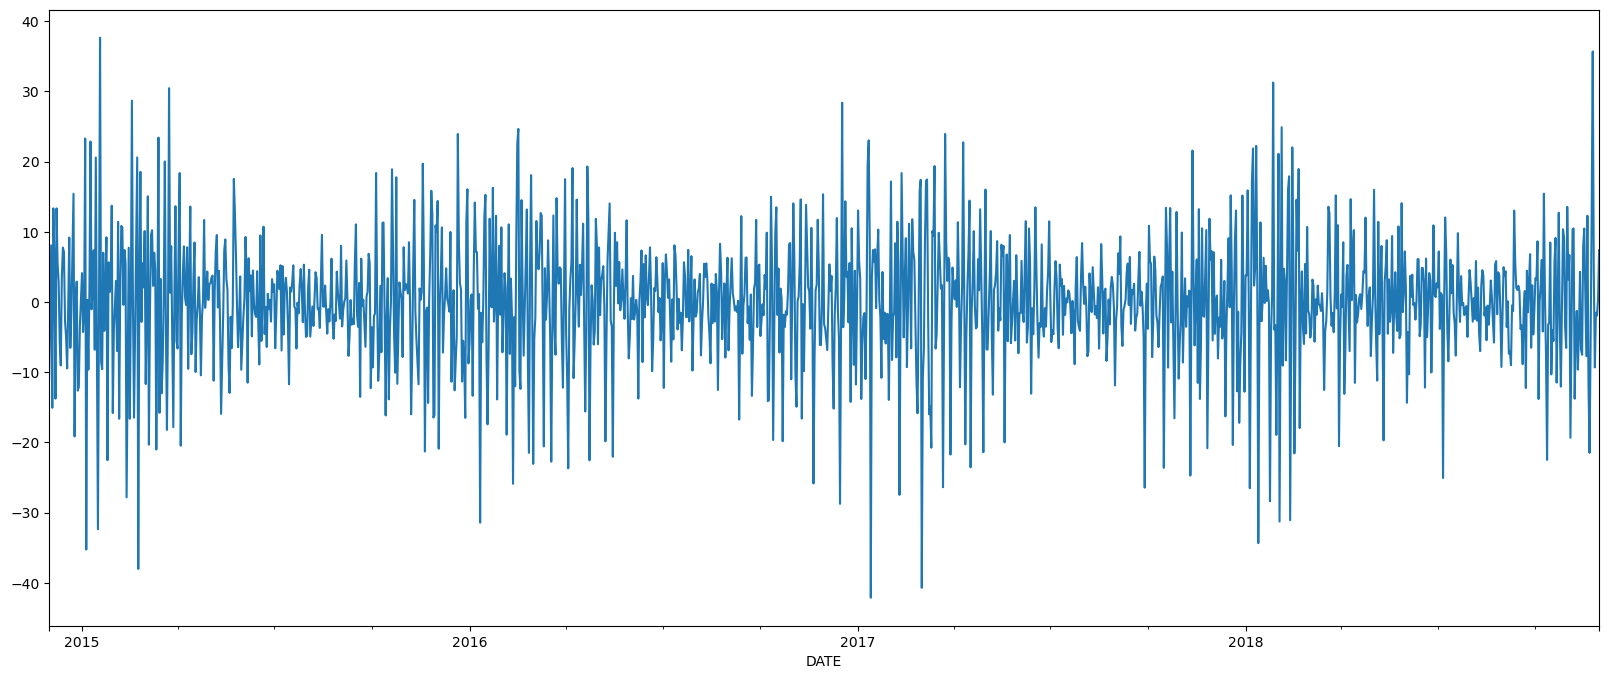

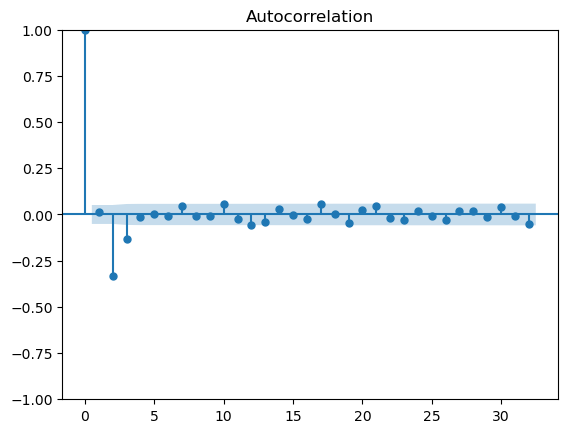

In [15]:
# Residuals Diagnostics
MtWashington_weather["Residual"] = MtWashington_weather['MinTemp'] - MtWashington_weather['MinTemp_HoltW']
MtWashington_weather["Residual"].plot(figsize=(20, 8));
plot_acf(MtWashington_weather["Residual"]);

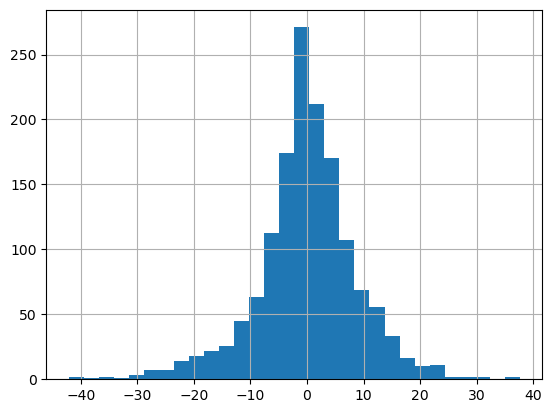

In [16]:
MtWashington_weather["Residual"].hist(bins = 30);

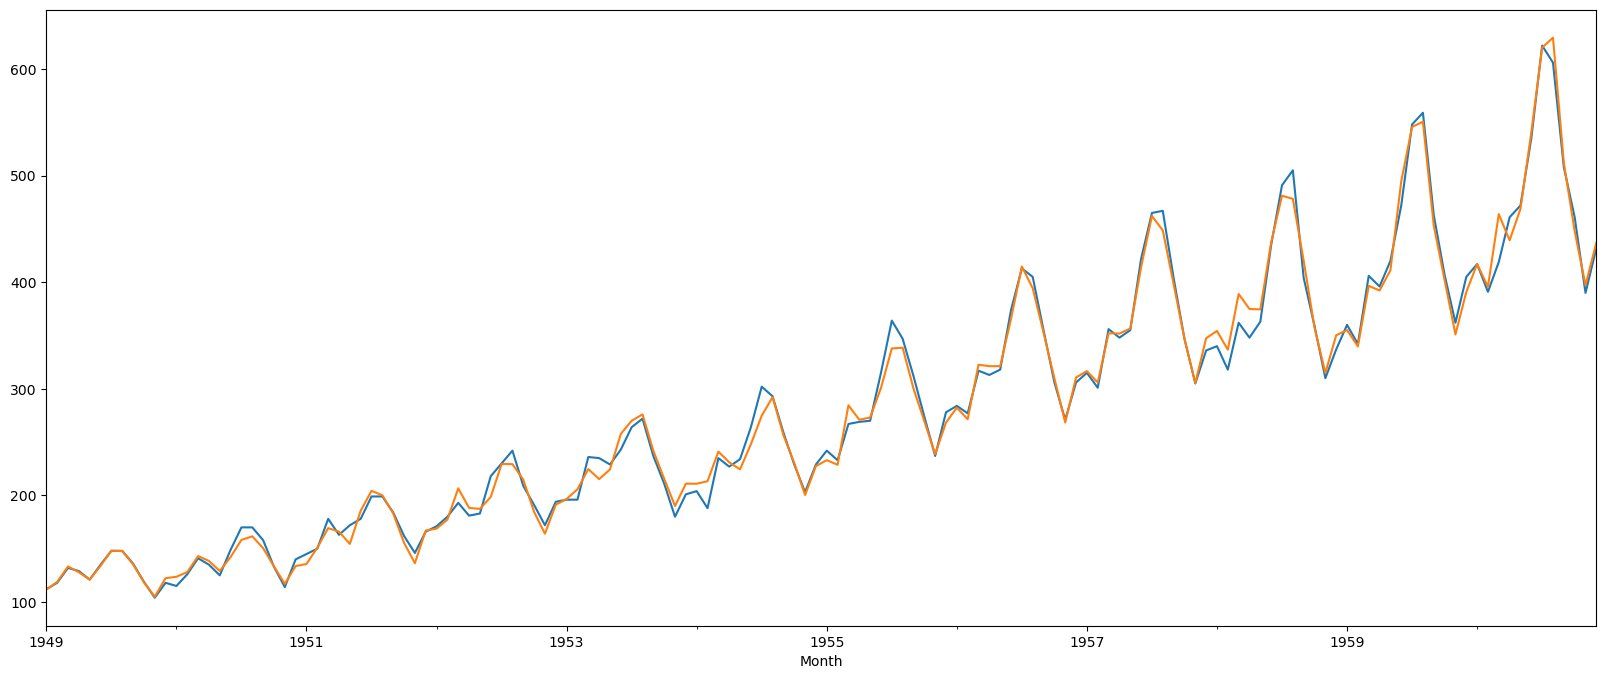

In [17]:
# Holt-Winter's seasonal method with multiplicative trend and seasonality
airline_passengers["Passengers_ExpTrendSeas"] = ExponentialSmoothing(airline_passengers["Passengers"],  trend = "mul",seasonal="mul",seasonal_periods=12).fit().fittedvalues
airline_passengers['Passengers'].plot(figsize=(20, 8))
airline_passengers["Passengers_ExpTrendSeas"].plot(figsize=(20, 8));

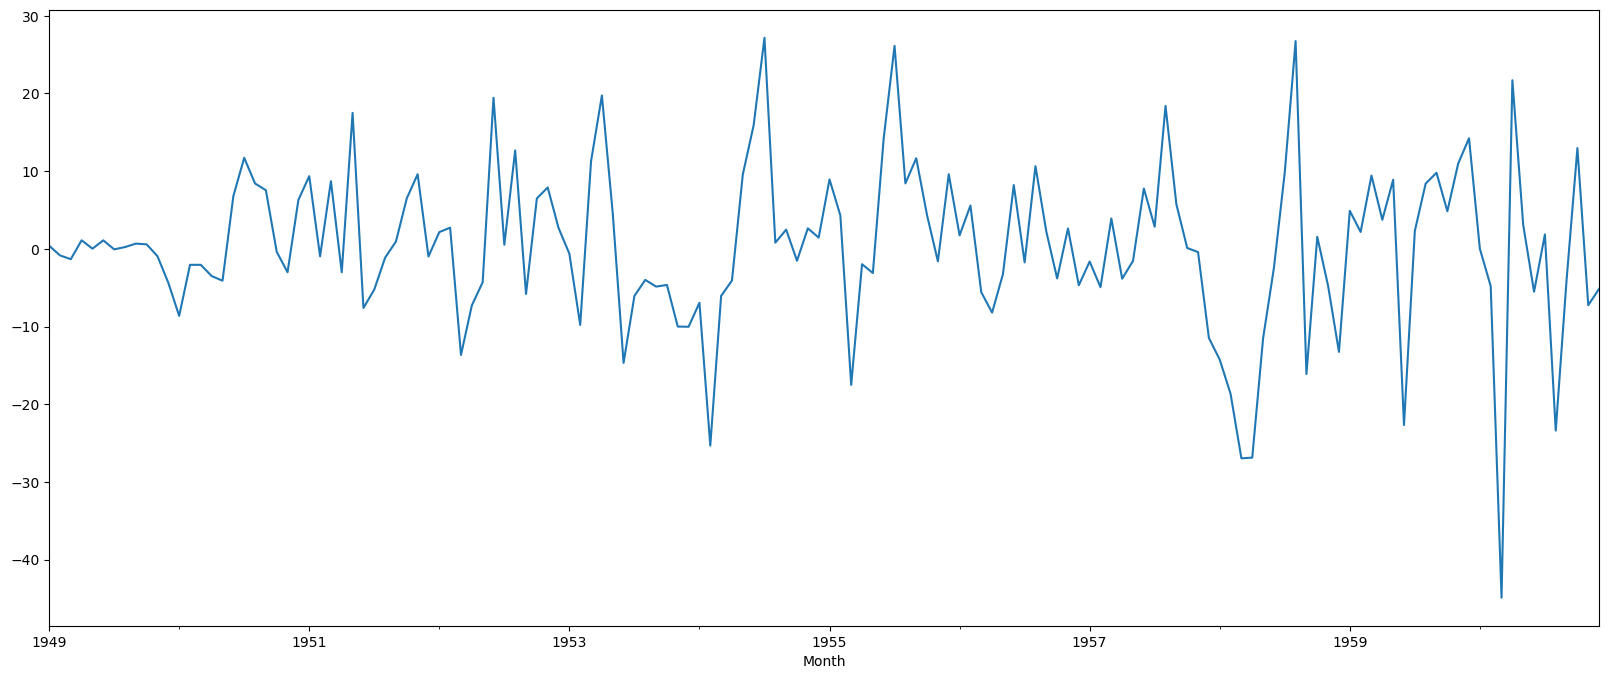

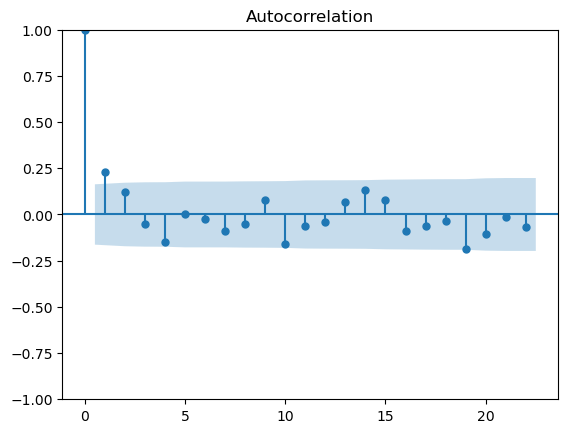

In [18]:
# Residuals
airline_passengers["Residual"] = airline_passengers["Passengers"] - airline_passengers["Passengers_ExpTrendSeas"]
airline_passengers["Residual"].plot(figsize=(20, 8));
plot_acf(airline_passengers["Residual"]);

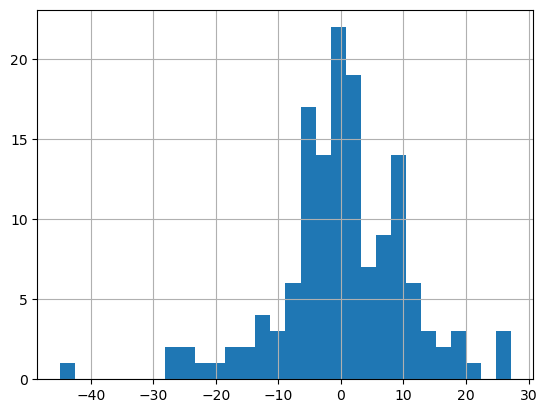

In [19]:
airline_passengers["Residual"].hist(bins = 30);

In [20]:
sm.stats.acorr_ljungbox(airline_passengers["Residual"], boxpierce = True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,7.931637,0.004858,7.768658,0.005316
2,10.104291,0.006396,9.881787,0.007148
3,10.481365,0.014888,10.245948,0.016587
4,13.916052,0.007568,13.539483,0.008920
5,13.918387,0.016136,13.541706,0.018798
6,14.007500,0.029552,13.625937,0.034106
7,15.304701,0.032286,14.843173,0.038063
8,15.730555,0.046403,15.239859,0.054646
9,16.721291,0.053264,16.155951,0.063695
10,20.609287,0.023989,19.724385,0.031970


<Axes: xlabel='Month'>

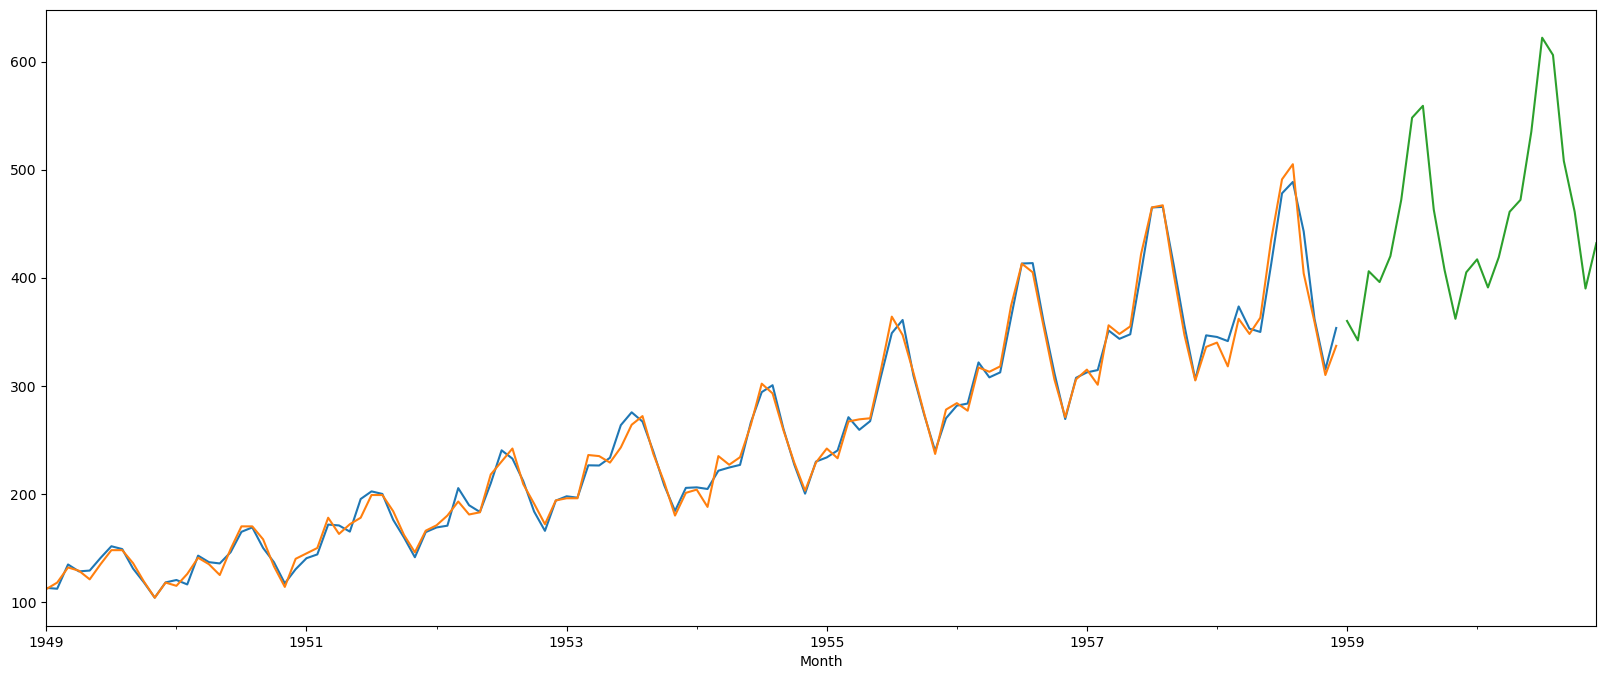

In [21]:
#Forecasting with ETS model
# Separate the series into training and test data
train=airline_passengers[0:120] 
test=airline_passengers[120:]

# Fit the model to the test data
ETSfit = ETSModel(train["Passengers"],error="mul",trend="mul",seasonal="mul",).fit()
train["FittedValues"] = ETSfit.fittedvalues
train["FittedValues"].plot(figsize=(20, 8))
train["Passengers"].plot(figsize=(20, 8))
test["Passengers"].plot(figsize=(20, 8))

In [22]:
# get predictions for test period
pred = ETSfit.get_prediction(start = test.index[0], end = test.index[len(test)-1])
print(pred.summary_frame(alpha=0.05))

                  mean  mean_numerical    pi_lower    pi_upper
1959-01-01  347.575940      347.270871  324.003001  370.639523
1959-02-01  347.763764      347.162515  319.812013  379.115495
1959-03-01  401.597777      401.003997  362.673680  442.380202
1959-04-01  388.673095      388.632022  344.419732  436.805105
1959-05-01  389.465001      389.576943  339.868741  440.466153
1959-06-01  446.358625      447.561139  387.337663  513.727351
1959-07-01  496.405184      497.483535  423.532613  576.865487
1959-08-01  496.982742      497.710896  422.307547  578.020814
1959-09-01  439.060555      440.000126  372.620853  513.331838
1959-10-01  384.720841      385.082085  323.583640  458.733799
1959-11-01  337.033612      335.882177  277.711156  399.470783
1959-12-01  382.899300      381.728062  311.772678  463.466597
1960-01-01  390.533201      389.669480  317.387377  475.473185
1960-02-01  390.744238      389.902941  310.369857  476.151667
1960-03-01  451.231652      449.454569  359.276813  552

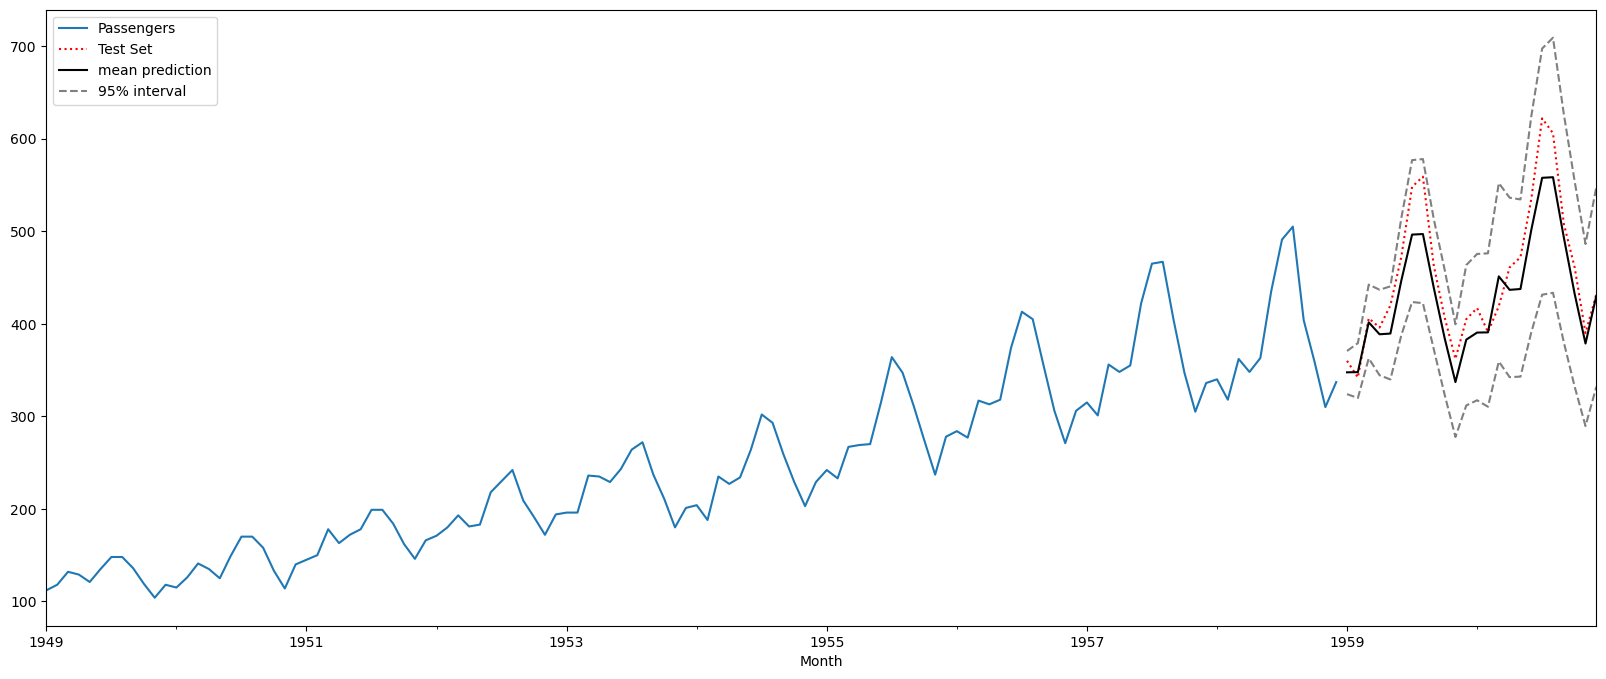

In [23]:

pred_df = pred.summary_frame(alpha=0.05)

train["Passengers"].plot(figsize=(20, 8))
test["Passengers"].plot(figsize=(20, 8), linestyle="dotted", color="red", label="Test Set")
pred_df["mean"].plot(label="mean prediction", color="black")
pred_df["pi_lower"].plot(linestyle="--", color="grey", label="95% interval")
pred_df["pi_upper"].plot(linestyle="--", color="grey", label="_")
plt.legend()

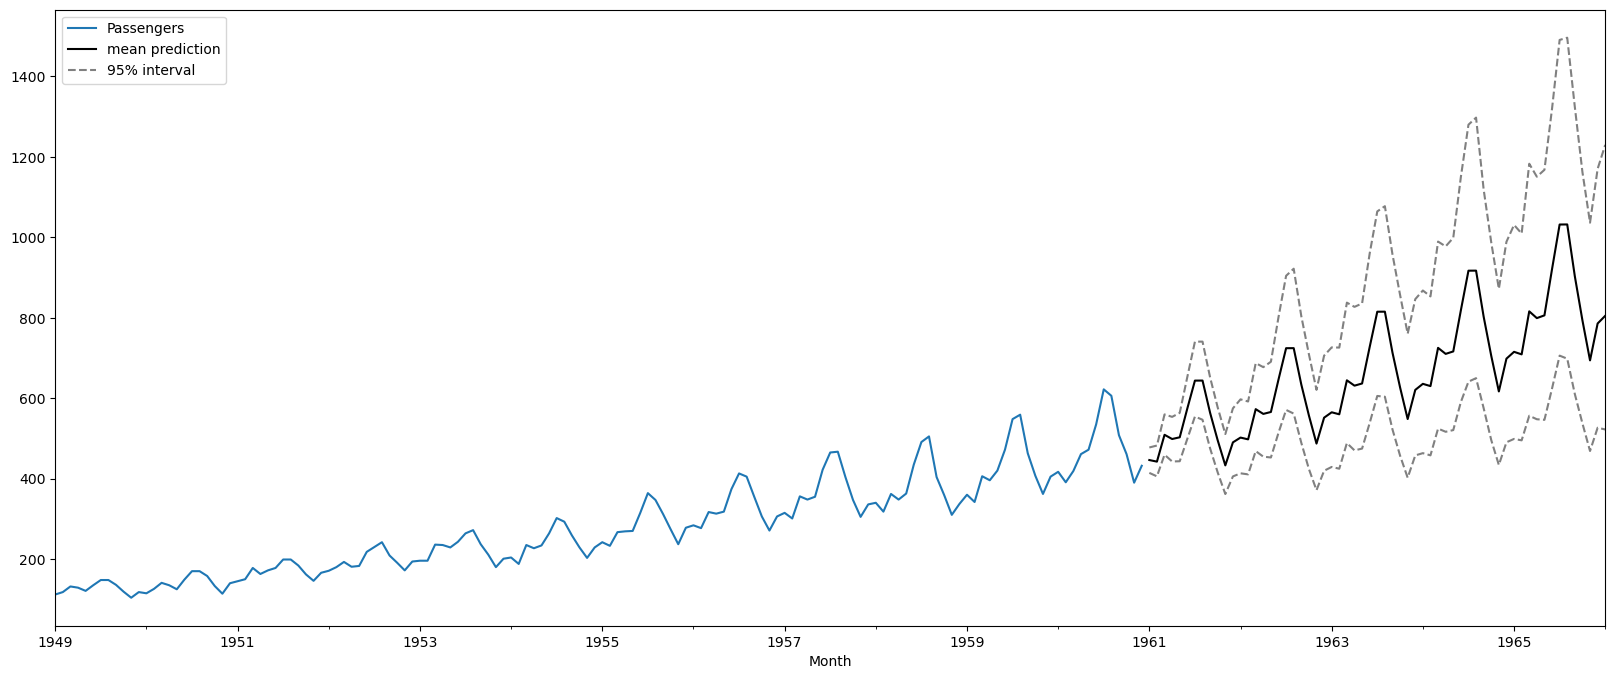

In [24]:
# Forecasting in unknown future
ETSfit = ETSModel(airline_passengers["Passengers"],error="mul",trend="mul",seasonal="mul",).fit()
airline_passengers["FittedValues"] = ETSfit.fittedvalues
prediction = ETSfit.get_prediction(start=144, end=204)

prediction_df = prediction.summary_frame(alpha=0.05)

airline_passengers["Passengers"].plot(figsize=(20, 8))
prediction_df["mean"].plot(label="mean prediction", color="black")
prediction_df["pi_lower"].plot(linestyle="--", color="grey", label="95% interval")
prediction_df["pi_upper"].plot(linestyle="--", color="grey", label="_")
plt.legend()